# Simple Jax (autograd optimized) NN from Scratch

This notebook combines all the jax features used so far (jit, autograd and vmap). This notebook demonstrates how clean and fast Jax can become by using all its features together, whilst not losing control over the low level functionality of the model.


In [58]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
import jax
import jax.numpy as jnp
from jax import random
from jax import nn
from jax import vmap
from jax import grad
from keras.utils import data_utils

Check if the training data exists. If not, automatically download it.

In [59]:
data_dir = os.path.abspath("./digit-recognizer")
os.makedirs(data_dir, exist_ok=True)
train_data_path = f"{data_dir}/train.csv"
train_data_url = "https://huggingface.co/datasets/ChristianOrr/mnist/resolve/main/train.csv"

if not os.path.exists(train_data_path):
    print("Downloading training data...")
    data_utils.get_file(train_data_path, train_data_url)

data_df = pd.read_csv('./digit-recognizer/train.csv')

In [60]:
np.random.shuffle(data_df.values)
m, n = data_df.shape
Y = jnp.array(data_df["label"])
data_df = data_df.drop("label", axis=1)
X = jnp.array(data_df)


X_train = X[1000:]
X_train = X_train / 255.
Y_train = Y[1000:]

X_val = X[:1000]
X_val = X_val / 255.
Y_val = Y[:1000]

Our NN will have a simple two-layer architecture. Input layer $A^{[0]}$ will have 784 units corresponding to the 784 pixels in each 28x28 input image. A hidden layer $A^{[1]}$ will have 10 units with ReLU activation, and finally our output layer $A^{[2]}$ will have 10 units corresponding to the ten digit classes with softmax activation.


**Forward propagation**

Input Layer:    
$$X = A^{[0]}$$

First Hidden Layer:
$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]})$$

Second Hidden Layer:
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

Loss Function (Categorical Cross Entropy):  
$$L(y, a^{[2]}) = -\sum_{j = 1}^{C}y_{j} \cdot\ log(a^{[2]})$$ 
C is the number of classes, which is 10 in this case. 

Cost Function:
$$J(W, b) = -\frac{1}{m} \sum_{i = 1}^{m} L(y^{i}, a^{[2](i)})$$ 
$$J(W, b) = -\frac{1}{m} \sum_{i = 1}^{m} \sum_{j = 1}^{C}y^{i}_{j}\cdot\log(a^{[2](i)})$$ 
The cost function is the average of the losses over all the samples.

Derivatives:    
For detailed derivation of $dZ^{[2]}$ see: [derivation-of-categorical-cross-entropy-loss](https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1)    
For more details on the rest of the derivations see: [backpropagation-intuition](https://www.youtube.com/watch?v=yXcQ4B-YSjQ&list=PLkDaE6sCZn6Ec-XTbcX1uRg2_u4xOEky0&index=34&ab_channel=DeepLearningAI)
$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \sum_{i = 1}^{m} {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \sum_{i = 1}^{m} {dZ^{[1]}}$$

**Gradient Descent (parameter updates)**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

In [61]:
@jax.jit
def init_params():
    key = random.PRNGKey(42)
    key, *subkey = random.split(key, 5)
    W1 = random.uniform(subkey[0], (10, 784), jnp.float32, -0.5, 0.5)
    b1 = random.uniform(subkey[1], (10,), jnp.float32, -0.5, 0.5)
    W2 = random.uniform(subkey[2], (10, 10), jnp.float32, -0.5, 0.5)
    b2 = random.uniform(subkey[3], (10,), jnp.float32, -0.5, 0.5)
    return W1, b1, W2, b2

@jax.jit
def ReLU(Z):
    return jnp.maximum(Z, 0)

@jax.jit
def softmax(Z):
    A = jnp.exp(Z) / sum(jnp.exp(Z))
    return A   

@jax.jit
def forward(W1, b1, W2, b2, x):
    # single example forward pass
    z1 = W1.dot(x) + b1
    a1 = ReLU(z1)
    z2 = W2.dot(a1) + b2
    a2 = softmax(z2)
    return a2

batched_forward = jax.jit(vmap(forward, in_axes=(None, None, None, None, 0)))


Only the one_hot function needed to have a static argument since the value of k was used in the function. All the rest could be jitted exactly as they were. 

In [62]:
@partial(jax.jit, static_argnames=['k'])
def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[:, None] == jnp.arange(k), dtype)

@jax.jit
def loss_fn(W1, b1, W2, b2, X, Y):
    A2 = batched_forward(W1, b1, W2, b2, X)
    one_hot_Y = one_hot(Y, 10)
    loss = -jnp.sum(one_hot_Y * jnp.log(A2)) / m
    return loss

@jax.jit
def update_params(W1, b1, W2, b2, alpha, X, Y):
    dW1, db1, dW2, db2 = grad(loss_fn, argnums=(0, 1, 2, 3))(W1, b1, W2, b2, X, Y)
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2


In [63]:
@jax.jit
def get_predictions(A2):
    return jnp.argmax(A2, axis=1)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return jnp.mean(predictions == Y)

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, alpha, X, Y)
        if i % 10 == 0:
            print("Iteration: ", i)
            A2 = batched_forward(W1, b1, W2, b2, X)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [64]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 500)

Iteration:  0
[6 3 8 ... 6 6 6] [2 6 8 ... 4 2 3]
0.12307317
Iteration:  10
[1 6 8 ... 6 3 0] [2 6 8 ... 4 2 3]
0.25336584
Iteration:  20
[1 6 8 ... 1 3 0] [2 6 8 ... 4 2 3]
0.34129268
Iteration:  30
[1 1 8 ... 1 3 0] [2 6 8 ... 4 2 3]
0.39712194
Iteration:  40
[2 1 8 ... 1 3 0] [2 6 8 ... 4 2 3]
0.44929266
Iteration:  50
[3 1 8 ... 4 3 0] [2 6 8 ... 4 2 3]
0.5004634
Iteration:  60
[3 1 8 ... 4 3 3] [2 6 8 ... 4 2 3]
0.5437317
Iteration:  70
[3 1 8 ... 4 3 3] [2 6 8 ... 4 2 3]
0.5816829
Iteration:  80
[3 1 8 ... 4 3 3] [2 6 8 ... 4 2 3]
0.60802436
Iteration:  90
[3 1 8 ... 4 3 3] [2 6 8 ... 4 2 3]
0.62985367
Iteration:  100
[3 1 8 ... 4 3 3] [2 6 8 ... 4 2 3]
0.64982927
Iteration:  110
[3 1 8 ... 4 3 3] [2 6 8 ... 4 2 3]
0.6669024
Iteration:  120
[2 1 8 ... 4 3 3] [2 6 8 ... 4 2 3]
0.68109757
Iteration:  130
[2 2 8 ... 4 3 3] [2 6 8 ... 4 2 3]
0.69382924
Iteration:  140
[2 2 8 ... 4 3 3] [2 6 8 ... 4 2 3]
0.7034878
Iteration:  150
[2 2 8 ... 4 3 3] [2 6 8 ... 4 2 3]
0.7142439
Iteration

In [65]:
def make_predictions(X, W1, b1, W2, b2):
    A2 = batched_forward(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[None, index]
    prediction = make_predictions(X_train[None, index], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [2]
Label:  2


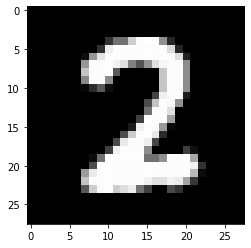

Prediction:  [6]
Label:  6


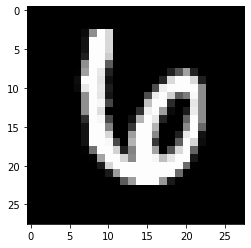

Prediction:  [8]
Label:  8


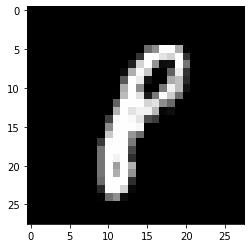

Prediction:  [6]
Label:  6


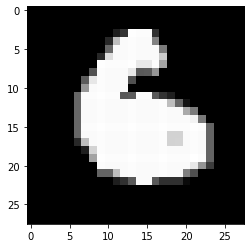

In [66]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

In [67]:
val_predictions = make_predictions(X_val, W1, b1, W2, b2)
get_accuracy(val_predictions, Y_val)

[5 4 6 9 9 2 6 7 2 6 6 6 8 5 4 7 9 7 1 0 6 2 3 4 2 8 0 7 1 7 9 8 9 0 7 1 7
 8 6 7 2 8 2 6 8 5 1 0 0 2 6 7 2 2 3 4 2 3 8 3 8 2 0 7 5 6 0 4 1 7 1 8 1 1
 1 7 5 3 3 2 6 4 1 9 6 4 1 0 5 9 8 6 4 8 1 5 2 4 2 1 7 4 6 1 6 6 3 6 3 4 1
 3 0 7 6 7 4 7 1 4 4 6 2 9 2 9 2 8 9 3 6 3 2 7 6 9 5 0 1 8 6 1 6 1 7 8 0 0
 3 7 0 3 9 6 1 1 3 1 1 6 1 5 2 6 8 0 3 2 2 8 8 6 6 3 8 8 1 9 6 7 7 9 0 6 1
 0 6 1 9 0 3 9 1 6 3 1 3 0 0 8 8 5 8 0 7 3 6 3 9 3 4 4 4 4 5 3 4 5 1 8 1 5
 8 2 8 6 0 8 1 0 0 4 4 5 0 6 4 4 1 0 8 8 1 8 3 3 9 9 1 7 8 4 1 1 2 0 3 6 2
 8 2 9 2 5 1 1 2 7 2 1 9 0 7 8 7 3 6 7 2 4 4 7 6 0 3 0 9 2 5 2 6 8 4 6 1 2
 1 0 5 1 4 4 9 0 5 5 1 8 3 3 1 4 1 0 0 4 1 8 8 9 0 4 5 5 7 9 3 7 2 6 4 5 4
 5 1 8 6 3 6 0 1 3 3 0 2 2 7 5 8 9 9 0 4 5 7 3 8 1 0 4 9 9 1 9 2 3 0 1 1 0
 4 5 0 3 1 1 5 2 3 9 4 3 9 7 4 3 4 1 7 1 1 1 1 6 3 1 6 1 3 2 4 4 2 9 6 2 6
 3 3 6 2 0 8 9 2 3 4 0 9 1 4 9 3 7 1 9 3 6 8 4 1 1 3 2 9 7 4 4 7 0 7 4 6 3
 1 7 7 3 3 6 0 1 8 7 1 6 3 4 2 7 7 3 3 5 2 0 4 0 0 6 9 9 3 6 7 9 4 6 2 8 1
 3 1 1 0 3 5 9 7 6 9 2 7 

DeviceArray(0.86800003, dtype=float32)

No loss in accuracy during training or inferencing compared to all other methods.

In [71]:
large_X_input = X_val.copy()

for i in range(6):
    large_X_input = jnp.concatenate((large_X_input, large_X_input), axis=0)

In [72]:
large_X_input.shape

(64000, 784)

In [83]:
%timeit batched_forward(W1, b1, W2, b2, large_X_input)

1.36 ms ± 1.22 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Conclusion

Jit enables an easy way to optimize your code. The training was significantly faster than all other methods, including the explicit jitted derivatives version (7.1s vs 1.3s). The standard autograd training was slower than the standard explicit derivatives version (14.7s vs 7.1s). So it was surprising to see how autograd combined with jit is faster than any other method. This provides an even bigger reason to use all Jax's tools together (jit, autograd and vmap).